# Data exploration
Evaluating the quality of data throughout the entire dataset

In [1]:
import sys
import pandas as pd
sys.path.append("../../xapres/")

import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import importlib
import gcsfs
import math
import datetime as dt
from datetime import timedelta

importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

# Set up dask cluster to help with computation
from dask.distributed import Client

client = Client("tcp://127.0.0.1:42747")
client

DEBUG    14:07:54 	 ApRESDefs.py @function _setup_logging line 539 - Stream logging level set to DEBUG
DEBUG    14:07:54 	 ApRESDefs.py @function _setup_logging line 540 - Add console handler to logger
DEBUG    14:07:54 	 ApRESDefs.py @function _setup_logging line 553 - File logging level set to DEBUG


<Client: 'tcp://127.0.0.1:42747' processes=4 threads=16, memory=125.81 GiB>

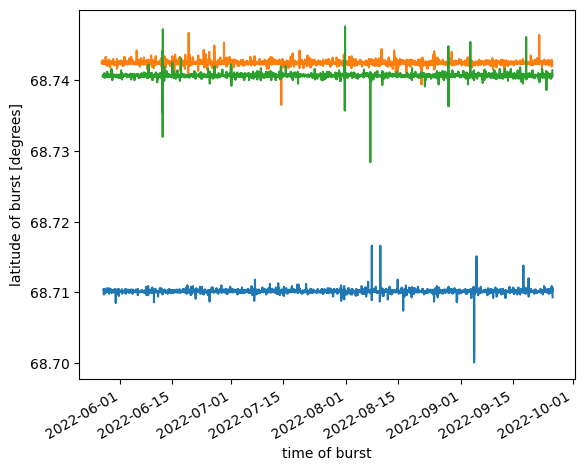

In [8]:
ds_101.latitude.isel(time=range(100,len(ds_101.latitude))).plot()
ds_103.latitude.isel(time=range(100,len(ds_103.latitude))).plot()
ds_104.latitude.isel(time=range(100,len(ds_104.latitude))).plot()


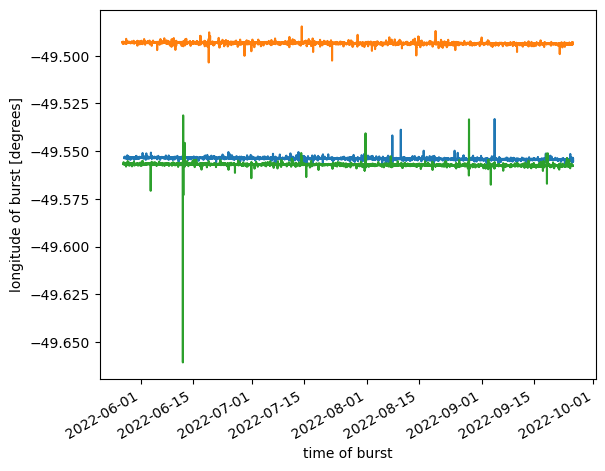

In [9]:
ds_101.longitude.isel(time=range(100,len(ds_101.longitude))).plot()
ds_103.longitude.isel(time=range(100,len(ds_103.longitude))).plot()
ds_104.longitude.isel(time=range(100,len(ds_104.longitude))).plot()

In [33]:
TS07 = pd.read_csv('../../secrets/TS07 2022-09-13 12_10_14 Greenland Daylight Time (Data Greenland Daylight Time).csv')
TS05 = pd.read_csv('../../secrets/TS05 2022-09-13 15_05_49 Greenland Daylight Time (Data Greenland Daylight Time).csv')
TS07["Date-Time (Greenland Daylight Time)"]= pd.to_datetime(TS07["Date-Time (Greenland Daylight Time)"]) +  timedelta(hours=2)
TS05["Date-Time (Greenland Daylight Time)"]= pd.to_datetime(TS05["Date-Time (Greenland Daylight Time)"]) +  timedelta(hours=2)


In [42]:
TS07_xr =  TS07.rename(columns={"Date-Time (Greenland Daylight Time)": "time",
                               "Ch: 1 - Temperature   (°C)": "temperature",
                               "Ch: 2 - RH   (%)": "RH",
                               "Dew Point   (°C)":"dew_point"},errors="raise").set_index('time').to_xarray()
TS05_xr =  TS05.rename(columns={"Date-Time (Greenland Daylight Time)": "time",
                               "Ch: 1 - Temperature   (°C)": "temperature",
                               "Ch: 2 - RH   (%)": "RH",
                               "Dew Point   (°C)":"dew_point"},errors="raise").set_index('time').to_xarray()


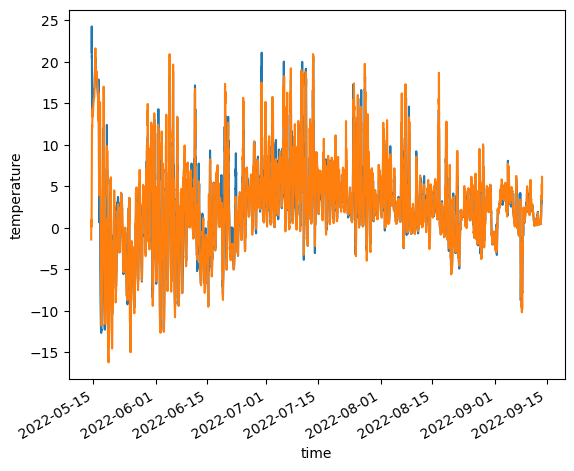

In [43]:
TS07_xr.temperature.plot()
TS05_xr.temperature.plot()

(19141.0, 19151.0)

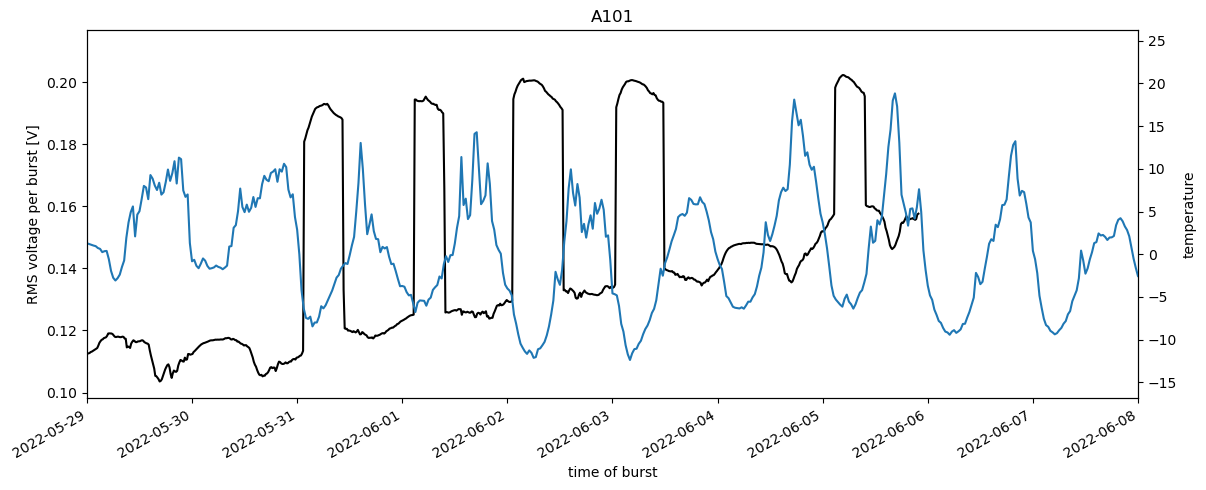

In [44]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(nrows=1,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
stn_names = ['A101','A103','A104']
gain = [-4,-14]
for j in [0]:
    for i in [0]:
        to_plot = abs(stn[j].chirp.isel(attenuator_setting_pair=i,time=range(100,1000))).mean(dim=['chirp_time','chirp_num'])
        to_plot.plot(ax=ax,color='black',label = f'Gain = {gain[i]} dB')
        
    ax.set_title(stn_names[j])
    ax.set_ylabel('RMS voltage per burst [V]')
    #ax[j].set_xlabel(' ')
    #ax[j].legend()
ax2 = ax.twinx()
TS07_xr.temperature.plot(ax=ax2)
plt.tight_layout()
ax.set_xlabel('time of burst')
plt.xlim([dt.date(2022, 5, 29), dt.date(2022, 6, 8)])
#plt.savefig('demo.png', transparent=True)

First let's look at the mean absolute value of each burst over time - gives an analogue for amplitude

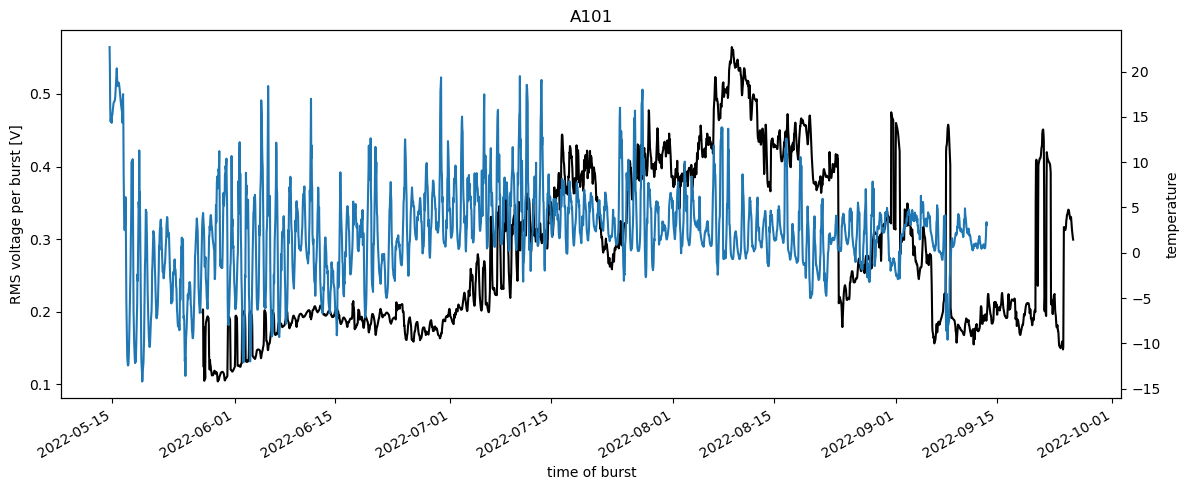

In [46]:
fig = plt.figure(figsize=(12, 5))
ax = fig.subplots(nrows=1,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
stn_names = ['A101','A103','A104']
gain = [-4,-14]
for j in [0]:
    for i in [0]:
        to_plot = abs(stn[j].chirp.isel(attenuator_setting_pair=i,time=range(100,len(stn[j].time)))).mean(dim=['chirp_time','chirp_num'])
        to_plot.resample(time='1H').mean(dim='time').plot(ax=ax,color='black',label = f'Gain = {gain[i]} dB')
        
    ax.set_title(stn_names[j])
    ax.set_ylabel('RMS voltage per burst [V]')
    #ax[j].set_xlabel(' ')
    #ax[j].legend()
ax2 = ax.twinx()
TS07_xr.temperature.resample(time='1H').mean(dim='time').plot(ax=ax2)

plt.tight_layout()
ax.set_xlabel('time of burst')
plt.savefig('demo.png', transparent=True)

Text(0.5, 108.22286656924005, 'time of burst')

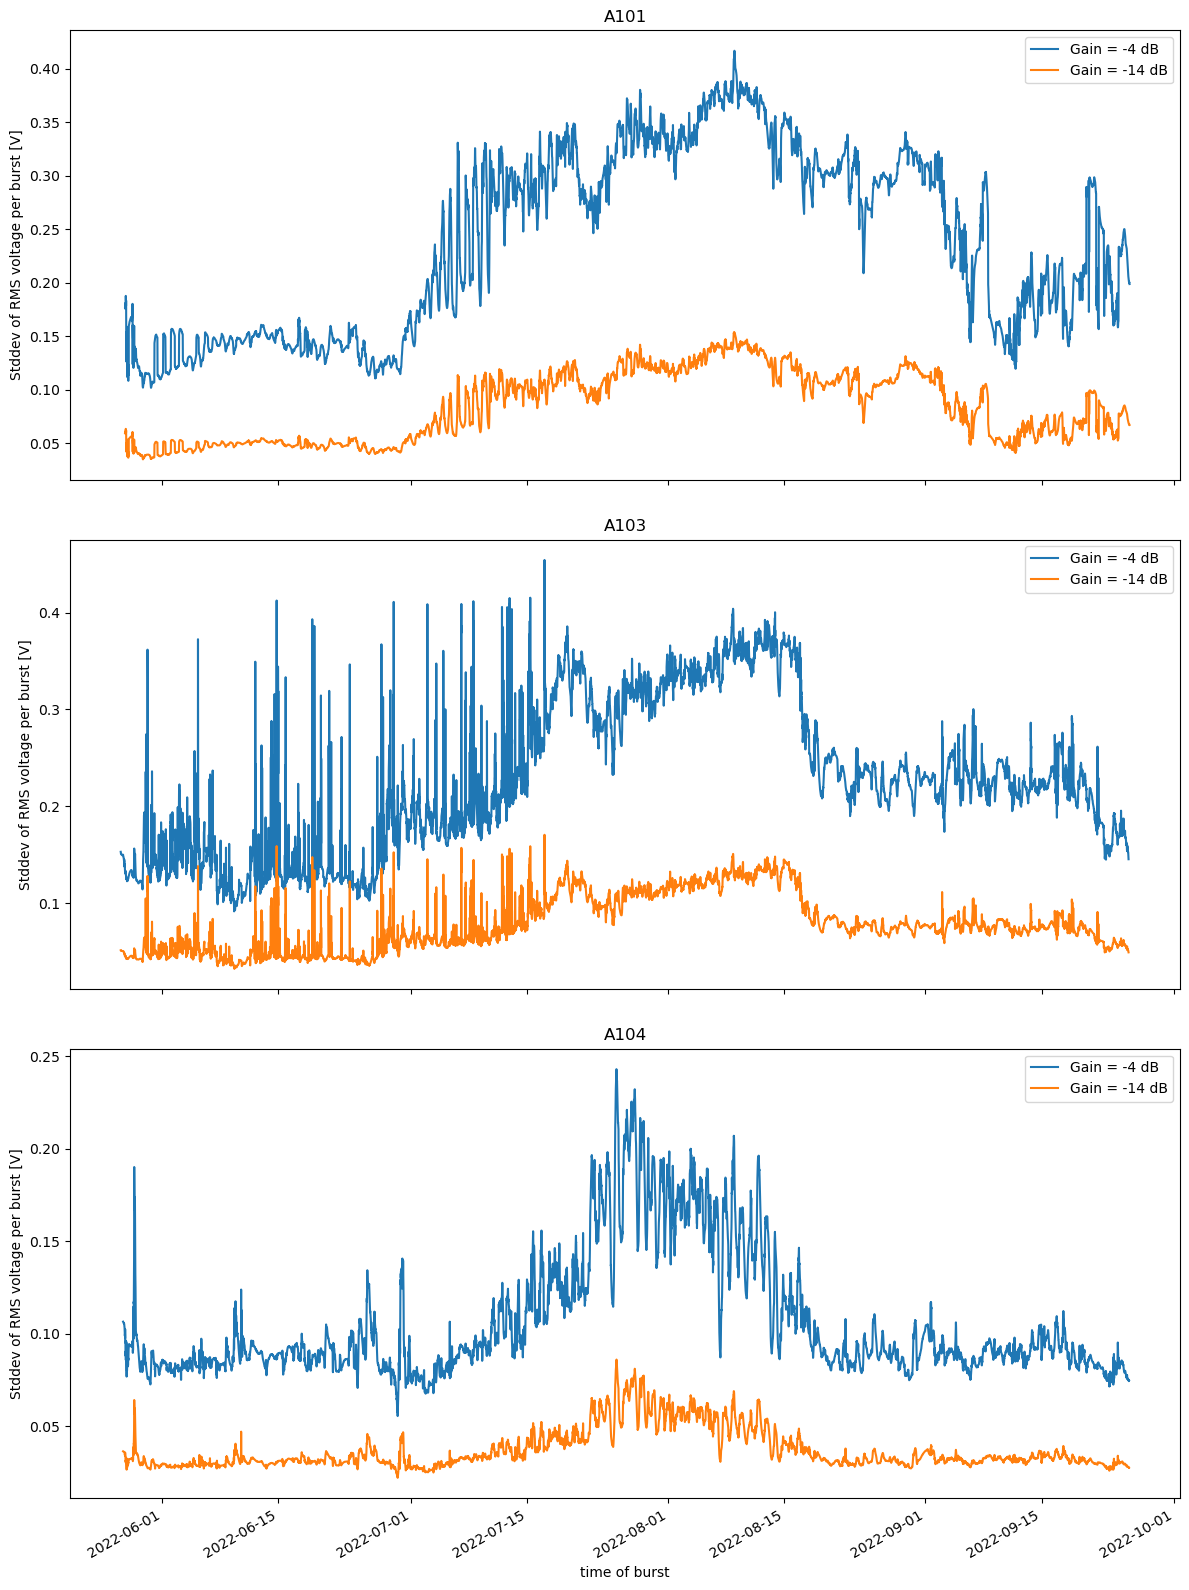

In [3]:
fig = plt.figure(figsize=(12, 16))
ax = fig.subplots(nrows=3,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
stn_names = ['A101','A103','A104']
gain = [-4,-14]
for j in [0,1,2]:
    for i in [0,1]:
        to_plot = abs(stn[j].chirp.isel(attenuator_setting_pair=i,time=range(100,len(stn[j].time)))).std(dim=['chirp_time','chirp_num'])
        to_plot.plot(ax=ax[j],label = f'Gain = {gain[i]} dB')
        
    ax[j].set_title(stn_names[j])
    ax[j].set_ylabel('Stddev of RMS voltage per burst [V]')
    ax[j].set_xlabel(' ')
    ax[j].legend()
plt.tight_layout()
ax[2].set_xlabel('time of burst')


Text(0.5, 108.22286656924005, 'time of burst')

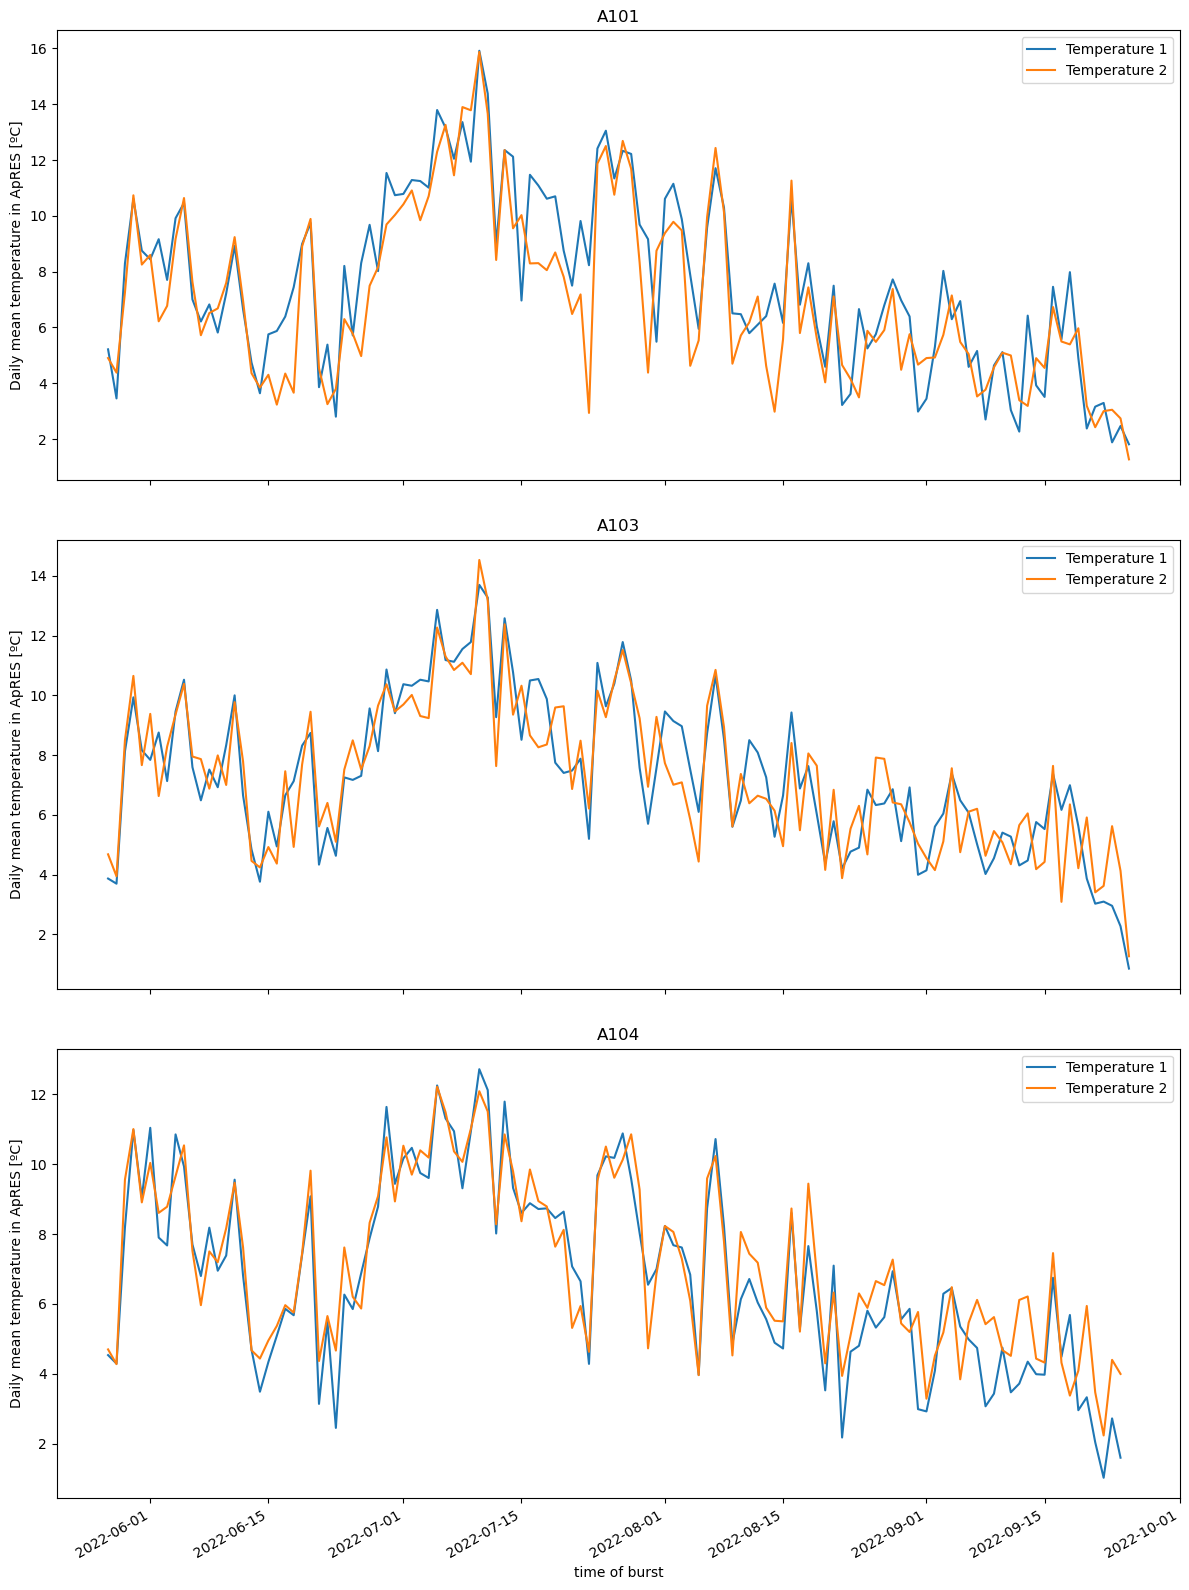

In [2]:
fig = plt.figure(figsize=(12, 16))
ax = fig.subplots(nrows=3,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
stn_names = ['A101','A103','A104']
gain = [-4,-14]
for j in [0,1,2]:
    to_plot = stn[j].temperature_1.isel(time=range(100,len(stn[j].time))).where(stn[j].temperature_1<100,drop=True).resample(time='1D').mean(dim='time')
    to_plot.plot(ax=ax[j],label = f'Temperature 1')
    to_plot = stn[j].temperature_2.isel(time=range(100,len(stn[j].time))).where(stn[j].temperature_2<100,drop=True).resample(time='1D').mean(dim='time')
    to_plot.plot(ax=ax[j],label = f'Temperature 2')
        
    ax[j].set_title(stn_names[j])
    ax[j].set_ylabel('Daily mean temperature in ApRES [ºC]')
    ax[j].set_xlabel(' ')
    ax[j].legend()
plt.tight_layout()
ax[2].set_xlabel('time of burst')


Text(0.5, 108.22286656924005, 'time of burst')

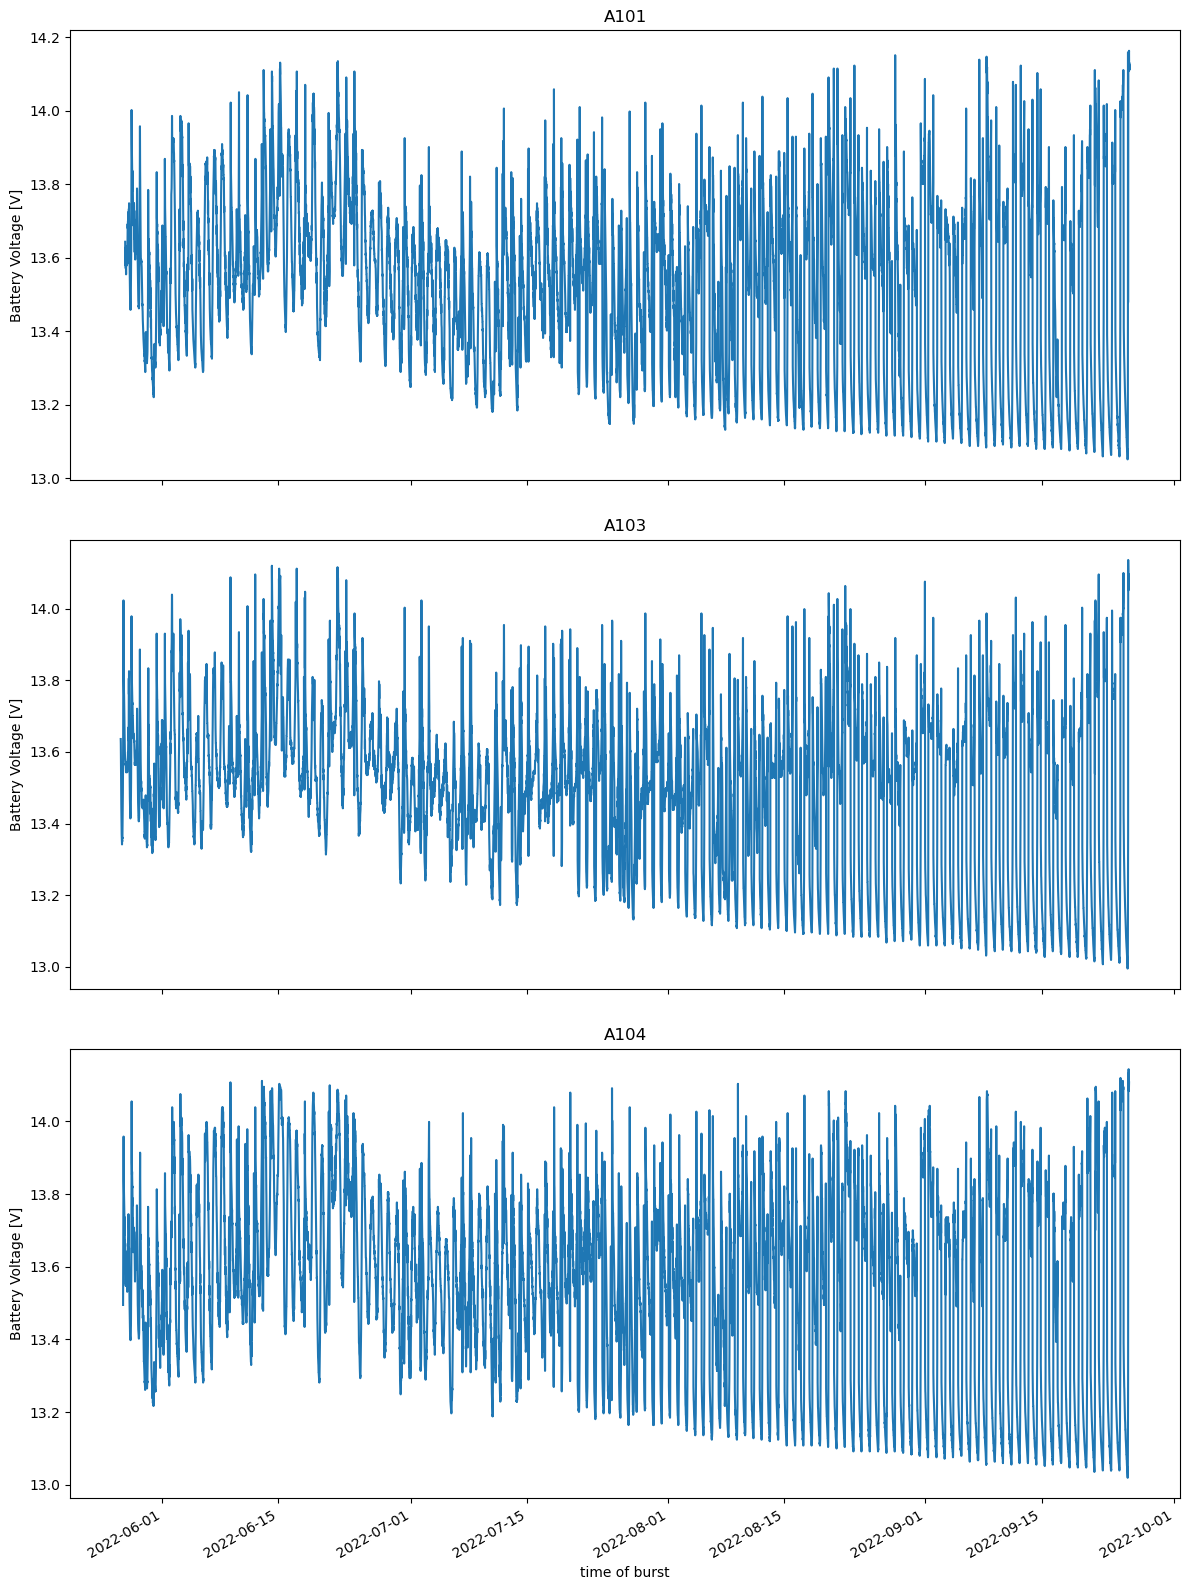

In [5]:
fig = plt.figure(figsize=(12, 16))
ax = fig.subplots(nrows=3,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
stn_names = ['A101','A103','A104']
gain = [-4,-14]
for j in [0,1,2]:
    to_plot = stn[j].battery_voltage.isel(time=range(100,len(stn[j].time)))
    to_plot.plot(ax=ax[j],label = f'Voltage')

        
    ax[j].set_title(stn_names[j])
    ax[j].set_ylabel('Battery Voltage [V]')
    ax[j].set_xlabel(' ')
plt.tight_layout()
ax[2].set_xlabel('time of burst')


(array([9.448000e+03, 1.553100e+04, 1.063580e+05, 6.626380e+05,
        3.228504e+06, 4.504633e+06, 1.142916e+06, 2.828040e+05,
        4.406800e+04, 3.100000e+03]),
 array([-0.49491882, -0.39532852, -0.29573822, -0.19614792, -0.09655762,
         0.00303268,  0.10262299,  0.20221329,  0.30180359,  0.40139389,
         0.50098419]),
 <BarContainer object of 10 artists>)

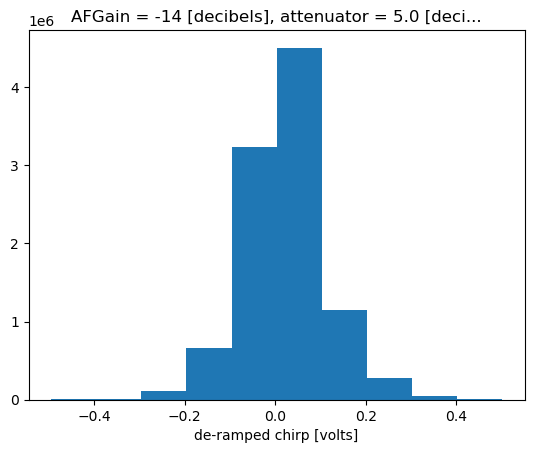

In [5]:
ds_101.isel(attenuator_setting_pair=1,time=range(100,200),chirp_time=range(0,5000)).chirp.plot()

Text(0.5, 108.22286656924005, 'time of burst')

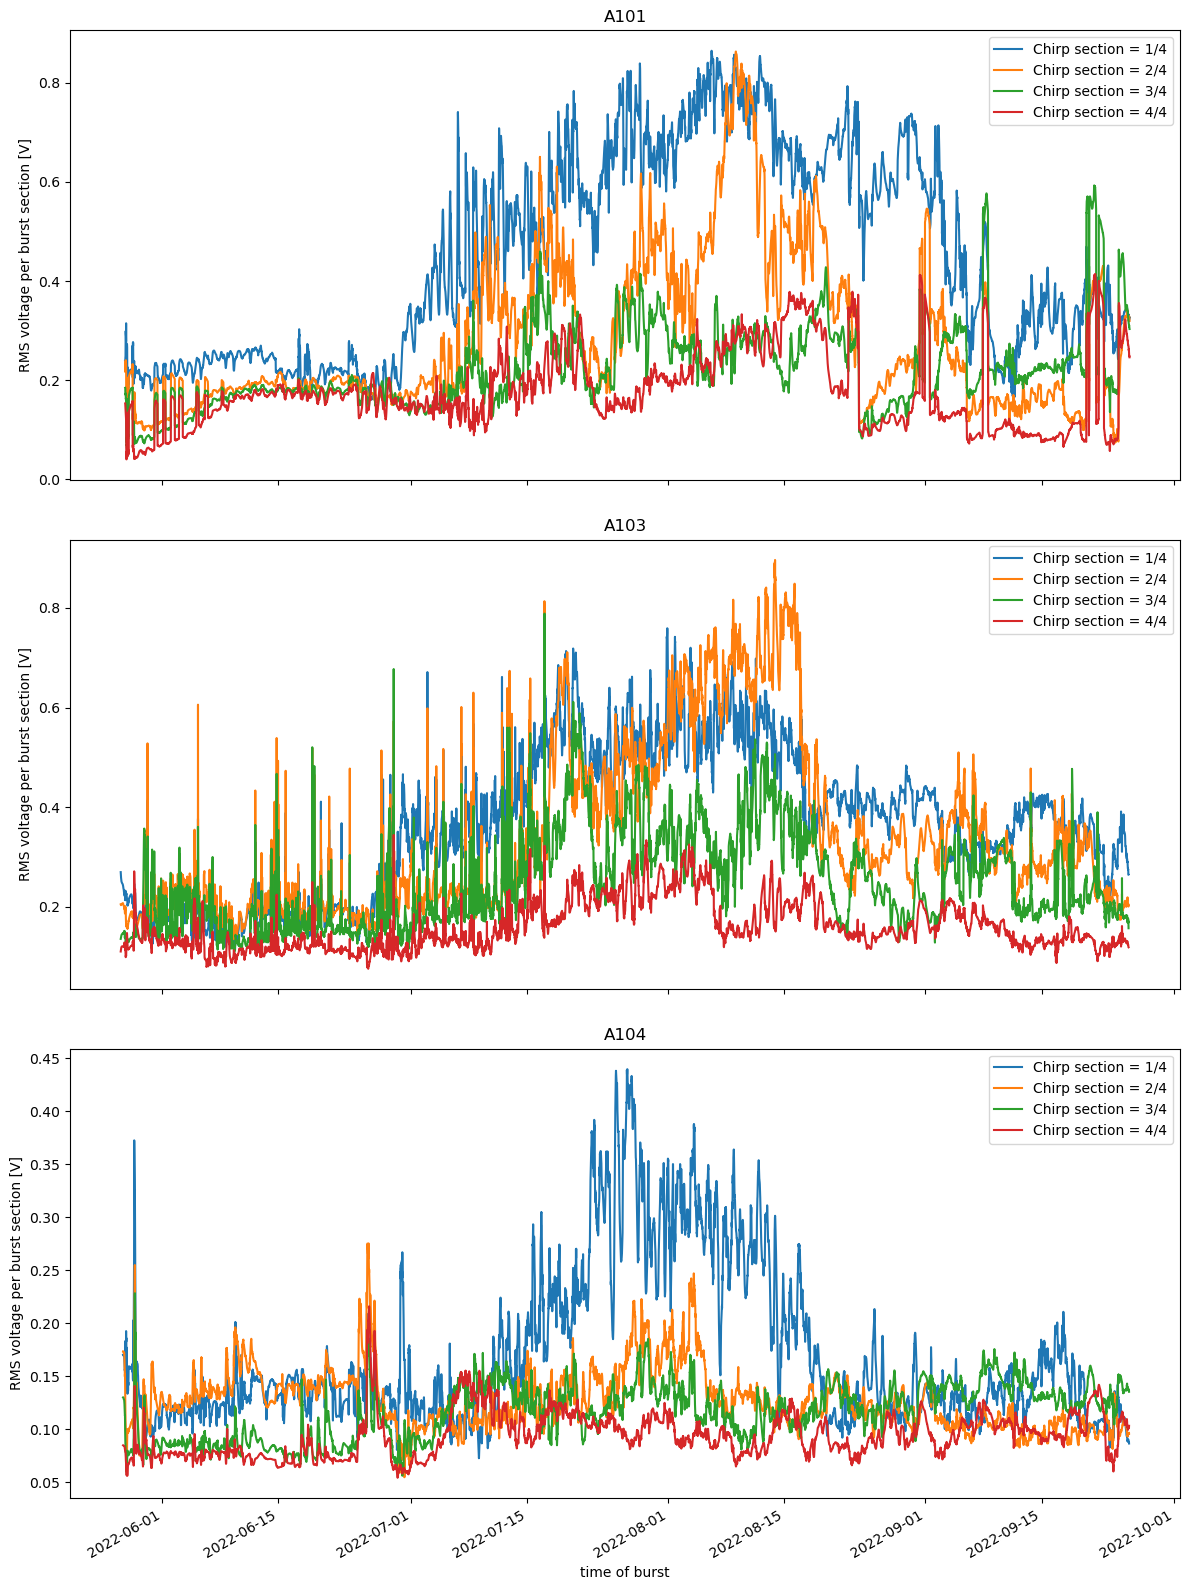

In [23]:
fig = plt.figure(figsize=(12, 16))
ax = fig.subplots(nrows=3,ncols=1, sharex=True)
stn = [ds_101,ds_103,ds_104]
#stn = [ds_101.isel(time = range(100,300))]
stn_names = ['A101','A103','A104']
freq_ranges = np.arange(0,40001,10000)
for j in [0,1,2]:
    for i in range(1,len(freq_ranges)):
        to_plot = abs(stn[j].chirp.isel(attenuator_setting_pair=0,time=range(100,len(stn[j].time)),chirp_time=range(freq_ranges[i-1],freq_ranges[i]))).mean(dim=['chirp_time','chirp_num'])
        to_plot.plot(ax=ax[j],label = f'Chirp section = {i}/{len(freq_ranges)-1}')
        
    ax[j].set_title(stn_names[j])
    ax[j].set_ylabel('RMS voltage per burst section [V]')
    ax[j].set_xlabel(' ')
    ax[j].legend()
plt.tight_layout()
ax[2].set_xlabel('time of burst')


In [22]:
len(freq_ranges)

5

In [13]:
freq_ranges = np.arange(0,40001,5000)
freq_ranges

array([    0,  5000, 10000, 15000, 20000, 25000, 30000, 35000, 40000])

In [29]:
ds_101.groupby('time.hour')

DatasetGroupBy, grouped over 'hour'
24 groups with labels 0, 1, 2, 3, 4, 5, ..., 19, 20, 21, 22, 23.